Homework 5
Yvonna Smothers

In [24]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyfixest as pf
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')

# To run in the terminal:
##python data-code/_BuildFinalData.py

# Load data
git_path = "https://github.com/imccart/Insurance-Access/raw/refs/heads/master/data/output/"
final_data = pd.read_csv(git_path + "acs_medicaid.txt", sep="\t")

insurance = pd.read_csv('data/input/acs_insurance.txt', sep='\t')
medicaid = pd.read_csv('data/input/acs_medicaid.txt', sep='\t')
expansion = pd.read_csv('data/input/medicaid_expansion.txt', sep='\t')

# Create percentage variables
final_data = (
    final_data.assign(
        perc_private=(final_data["ins_employer"] + final_data["ins_direct"]) / final_data["adult_pop"],
        perc_public=(final_data["ins_medicare"] + final_data["ins_medicaid"]) / final_data["adult_pop"],
        perc_ins=(final_data["adult_pop"] - final_data["uninsured"]) / final_data["adult_pop"],
        perc_unins=final_data["uninsured"] / final_data["adult_pop"],
        perc_employer=final_data["ins_employer"] / final_data["adult_pop"],
        perc_medicaid=final_data["ins_medicaid"] / final_data["adult_pop"],
        perc_medicare=final_data["ins_medicare"] / final_data["adult_pop"],
        perc_direct=final_data["ins_direct"] / final_data["adult_pop"],
    )
    .loc[~final_data["State"].isin(["Puerto Rico", "District of Columbia"])]
)


1. Plot the share of the adult population with direct purchase health insurance over time.

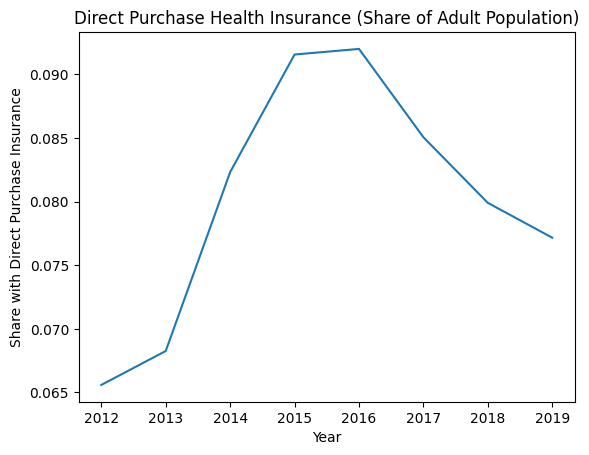

In [2]:
# Plot
direct_purchase_by_year = final_data.groupby('year')['perc_direct'].mean()

# Plot
direct_purchase_by_year.plot(title='Direct Purchase Health Insurance (Share of Adult Population)')
plt.xlabel('Year')
plt.ylabel('Share with Direct Purchase Insurance')
plt.show()

2. Discuss the reduction in direct purchase health insurance in later years. Can you list a couple of policies that might have affected the success of the direct purchase insurance market?

At first, more adults bought health insurance on their own through the ACA marketplaces. But in later years, this number went down. One reason is that the government removed the penalty for not having insurance in 2019, so some healthy people stopped buying it. Another reason is that new types of cheaper, less complete plans became available, and many people chose those instead. Also, the government spent less money helping people sign up for insurance. All of these changes made the individual insurance market less stable, so fewer people bought direct insurance.

3. Plot the share of the adult population with Medicaid over time.

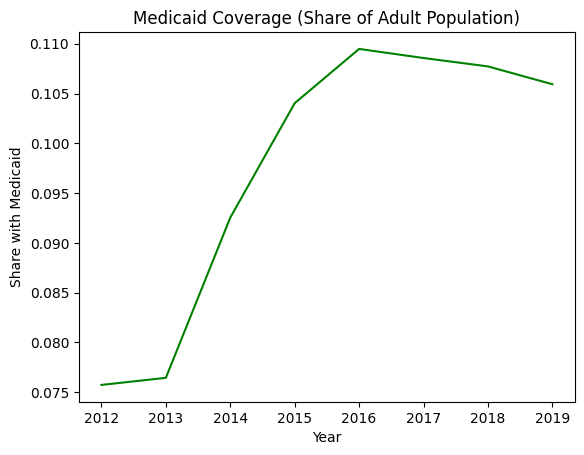

In [3]:
medicaid_by_year = final_data.groupby('year')['perc_medicaid'].mean()
medicaid_by_year.plot(title='Medicaid Coverage (Share of Adult Population)', color='green')
plt.xlabel('Year')
plt.ylabel('Share with Medicaid')
plt.show()

4. Plot the share of uninsured over time, separately by states that expanded Medicaid in 2014 versus those that did not.

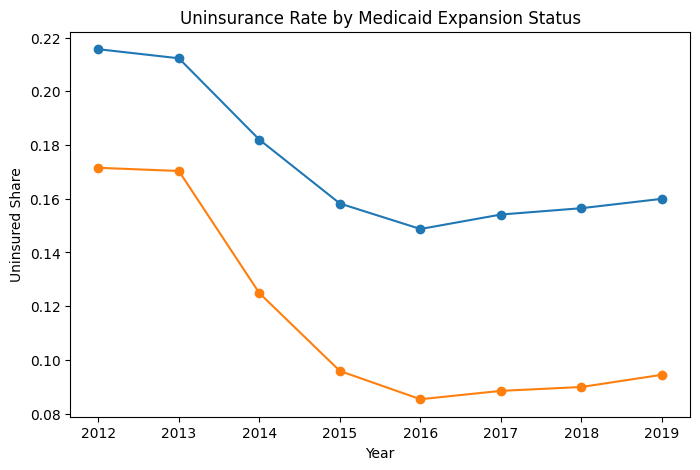

In [14]:

# Plot share uninsured
ins_plot_data = final_data[
    final_data["expand_year"].isna() | (final_data["expand_year"] == 2014)
]
ins_plot_summary = (
    ins_plot_data.groupby(["expand_ever", "year"])["perc_unins"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
for key, grp in ins_plot_summary.groupby("expand_ever"):
    plt.plot(grp["year"], grp["perc_unins"], marker="o", label="Expansion")

plt.title('Uninsurance Rate by Medicaid Expansion Status')
plt.xlabel('Year')
plt.ylabel('Uninsured Share')
plt.show()



5. Calculate the average percent of uninsured individuals in 2012 and 2015, separately for expansion and non-expansion states.

In [21]:
# Difference-in-Differences Table
reg_data = (
    final_data.copy()
    .loc[(final_data["expand_year"].isna()) | (final_data["expand_year"] == 2014)]
    .loc[final_data["year"].isin([2012, 2015])]
)

dd_table = (
    reg_data.groupby(["expand_ever", "year"])["perc_unins"]
    .mean()
    .reset_index()
    .pivot(index="expand_ever", columns="year", values="perc_unins")
    .rename(columns={2012: "Pre", 2015: "Post"})
    .reset_index()
)
dd_table["Group"] = dd_table["expand_ever"].map({False: "Non-expansion", True: "Expansion"})
dd_table = dd_table[["Group", "Pre", "Post"]]

def display_markdown_table(df):
    markdown = df.to_markdown(index=False)
    display(Markdown(markdown))

display_markdown_table(dd_table.round(3))

| Group         |   Pre |   Post |
|:--------------|------:|-------:|
| Non-expansion | 0.216 |  0.158 |
| Expansion     | 0.172 |  0.096 |

6. Estimate the effect of Medicaid expansion on the uninsurance rate using a standard DD regression estimator, again focusing only on states that expanded in 2014 versus those that never expanded.

In [25]:
# DD Regression (2014 expansion only)
reg_data = final_data.copy()
reg_data["post"] = (reg_data["year"] >= 2014).astype(int)
reg_data["treat"] = reg_data["post"] * reg_data["expand_ever"].astype(int)
reg_data = reg_data[(reg_data["expand_year"].isna()) | (reg_data["expand_year"] == 2014)]

# OLS regression without FE
results = []
results.append(
    pf.feols("perc_unins ~ post + expand_ever + treat", data=reg_data)
)


results_table = pf.etable(results, type='df',
                          drop='Intercept', coef_fmt='b (se)')
results_table = results_table.drop(index=['depvar', 'S.E. type'])
results_table.columns = ['Standard DD']
results_table.index = ['Post 2014', 'Expand', 'Post x Expand', 'Num. Obs.', 'R2']
results_table = results_table.reset_index(names='')

display_markdown_table(results_table)

ValueError: Length mismatch: Expected axis has 6 elements, new values have 5 elements

7. Include state and year fixed effects in your estimates.

In [28]:
dd_df = insurance_plot.copy()
dd_df['post'] = (dd_df['year'] >= 2014).astype(int)
dd_df['treated'] = (dd_df['group'] == 'Expanded 2014').astype(int)
dd_df['post_treated'] = dd_df['post'] * dd_df['treated']

model = sm.OLS.from_formula("uninsured ~ post + treated + post_treated + C(state) + C(year)", data=dd_df)
result = model.fit()
print(result.summary())

NameError: name 'insurance_plot' is not defined

In [29]:
results_table = pf.etable(results, type='df',
                          drop='Intercept', coef_fmt='b (se)')
results_table = results_table.drop(index=['depvar', 'S.E. type', 'State', 'year'])
results_table.columns = ['Standard DD', 'TWFE']
results_table.index = ['Post 2014', 'Expand', 'Post x Expand', 'Num. Obs.', 'R2']
results_table = results_table.reset_index(names='')

display_markdown_table(results_table)

KeyError: "['State', 'year'] not found in axis"

8. Repeat the analysis in question 7 but include all states (even those that expanded after 2014).

In [31]:
# DD with time-varying treatment
reg_data2 = final_data.copy()
reg_data2["treat"] = 0
reg_data2.loc[(reg_data2["year"] >= reg_data2["expand_year"]) & (reg_data2["expand_year"].notna()), "treat"] = 1

results.append(
    pf.feols("perc_unins ~ treat | State + year", data=reg_data2)
)


results_table = pf.etable(results, type='df',
                          drop='Intercept', coef_fmt='b (se)')
results_table = results_table.drop(index=['depvar', 'S.E. type', 'State', 'year'])
results_table.columns = ['Standard DD', 'TWFE', 'Time-varying Treatment']
results_table.index = ['Post 2014', 'Expand', 'Post x Expand', 'Num. Obs.', 'R2']
results_table = results_table.reset_index(names='')
display_markdown_table(results_table)


ValueError: Length mismatch: Expected axis has 2 elements, new values have 3 elements

9. Provide an “event study” graph showing the effects of Medicaid expansion in each year. Use the specification that includes state and year fixed effects, limited to states that expanded in 2014 or never expanded.

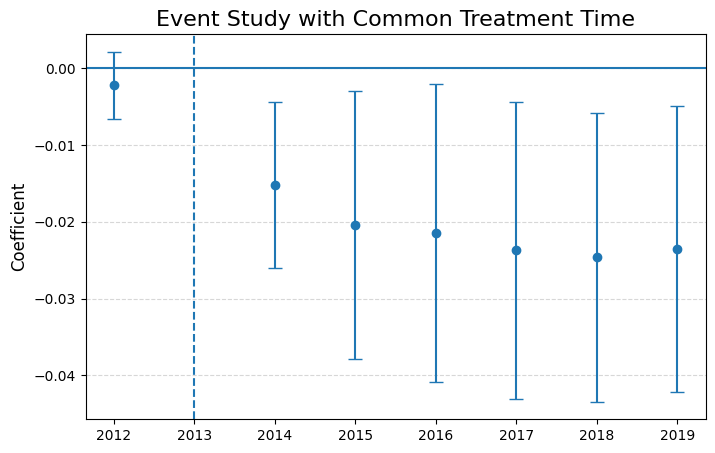

In [33]:
# Event Study with constant treatment
reg_data["relative_year"] = (reg_data["year"] - reg_data["expand_year"]).fillna(np.inf)

dynamic_twfe = pf.feols("perc_unins ~ i(relative_year, ref=-1) | State + year",
                 data=reg_data, vcov={"CRV1": "State"})


plt.figure(figsize=(8, 5))
joint_ci = dynamic_twfe.coef() - dynamic_twfe.confint(joint=True).T.iloc[0, :]
plt.errorbar(np.delete(np.arange(2012, 2020), 1), dynamic_twfe.coef(), 
             yerr=joint_ci, fmt='o', capsize=5)
plt.axvline(x=2013, linestyle="--")
plt.axhline(y=0, linestyle="-")
plt.title("Event Study with Common Treatment Time", fontsize=16)
plt.ylabel("Coefficient", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


10. Repeat part 9 but again include states that expanded after 2014.

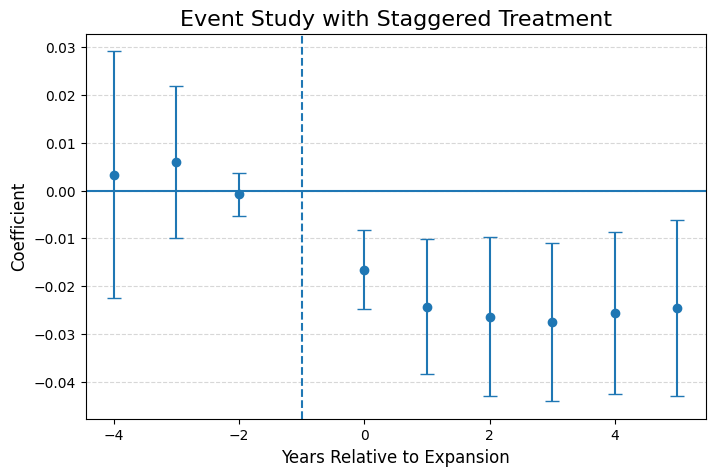

In [35]:
# ATE Q6: Event Study with time-varying treatment
reg_data2["relative_year"] = (reg_data2["year"] - reg_data2["expand_year"]).fillna(np.inf)
reg_data2["relative_year"] = reg_data2["relative_year"].clip(lower=-4)

dynamic_twfe2 = pf.feols("perc_unins ~ i(relative_year, ref=-1) | State + year",
                  data=reg_data2, vcov={"CRV1": "State"})


plt.figure(figsize=(8, 5))
joint_ci2 = dynamic_twfe2.coef() - dynamic_twfe2.confint(joint=True).T.iloc[0, :]
plt.errorbar(np.delete(np.arange(-4, 6), 3), dynamic_twfe2.coef(), 
             yerr=joint_ci2, fmt='o', capsize=5)
plt.axvline(x=-1, linestyle="--")
plt.axhline(y=0, linestyle="-")
plt.title("Event Study with Staggered Treatment", fontsize=16)
plt.ylabel("Coefficient", fontsize=12)
plt.xlabel("Years Relative to Expansion", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
